# Example of upper limit computation.

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np

import zfit
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimize import Minuit

from utils import plotfitresult, plotlimit, pltdist
import wrappers as wr

import os
os.chdir("/home/cms-jovyan/hepstats/hepstats/src")

# from hepstats.hypotests import UpperLimit
from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests.core.functions import upperlimit
from hepstats.utils import POI, POIarray
# from hepstats.hypotests.parameters import POI, POIarray

os.chdir("/home/cms-jovyan/hepstats/hepstats/notebooks/hypotests")
print(os.listdir())

/usr/local/lib/python3.12/site-packages/zfit/__init__.py:68: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


['confidenceinterval_asy_zfit.ipynb', 'FC_interval_freq.ipynb', 'asy_ci.png', '__pycache__', '.ipynb_checkpoints', 'counting.ipynb', 'asy_ul.png', 'wrappers.py', 'confidenceinterval_freq_zfit.ipynb', 'upperlimit_asy_zfit.ipynb', 'FC_interval_asy.ipynb', 'discovery_freq_zfit.ipynb', 'example_notebook.ipynb', '__init__.py', 'testbed.ipynb', 'discovery_asy_zfit.ipynb', 'toys', 'Simultaneous_fit_discovery_splot.ipynb', 'utils.py', 'upperlimit_freq_zfit.ipynb']


In [2]:
plt.rcParams["figure.figsize"] = (9, 8)
plt.rcParams["font.size"] = 16

### Fit of a Gaussian signal over an exponential background:

In [3]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1 / tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 10)
data = np.concatenate((data, peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

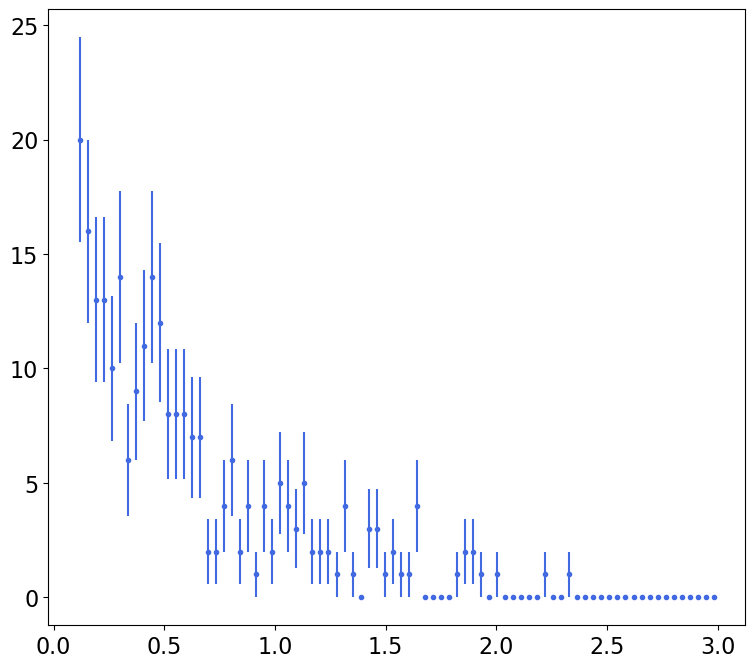

In [4]:
pltdist(data, bins=80, bounds=bounds)

In [5]:
obs = zfit.Space("x", limits=bounds)

In [6]:
zfit_lambda = zfit.Parameter("lambda", -2.0, -4.0, -1.0)
zfit_Nsig = zfit.Parameter("Nsig", 1.0, -20.0, len(data))
zfit_Nbkg = zfit.Parameter("Nbkg", len(data), 0.0, len(data) * 1.1)

signal = zfit.pdf.Gauss(obs=obs, mu=1.2, sigma=0.1).create_extended(zfit_Nsig)
background = zfit.pdf.Exponential(obs=obs, lambda_=zfit_lambda).create_extended(zfit_Nbkg)
tot_model = zfit.pdf.SumPDF([signal, background])

In [7]:
Nsig = wr.Parameter.from_zfit(zfit_Nsig)
Nbkg = wr.Parameter.from_zfit(zfit_Nbkg)
lambda_ = wr.Parameter.from_zfit(zfit_lambda)
    
bkg = wr.Parameter.concat([Nbkg, lambda_], floating=True)

params = {"signal" : Nsig, "background" : bkg}

In [8]:
unwrap_params = lambda p: {"Nsig" : p["signal"], "Nbkg" : p["background"][0], "lambda" : p["background"][1]}

data_dict = {"M" : data}
models_dict = {"M" : wr.ExtendedUnbinnedModel.from_zfit(tot_model, unwrap_params)}
data_nll = {"M" : wr.ExtendedUnbinnedNLL(models_dict["M"])}
constraint_nll = lambda params: 0

In [9]:
# instantation of the calculator
calculator = AsymptoticCalculator(
    data_nll, constraint_nll, params, data_dict,
    models=models_dict, blind=False, beta=200, unbinned_correction=True
)

bestfit = calculator.bestfit

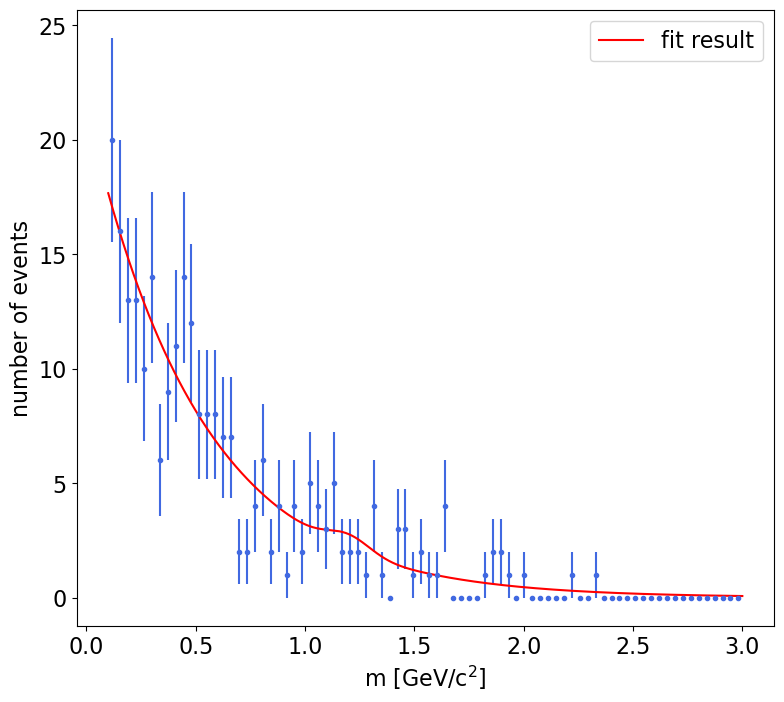

In [10]:
min_values = unwrap_params(bestfit.params)

for zfit_param in tot_model.get_params():
    zfit_param.set_value(min_values[zfit_param.name])

nbins = 80
pltdist(data, nbins, bounds)
plotfitresult(tot_model, bounds, nbins)

plt.xlabel("m [GeV/c$^2$]")
plt.ylabel("number of events")
plt.legend()

### Upper limit:

Since the signal yield Nsig = $4.5 \pm 5.8$  is consistent with zero signal we compute the CLs upper limit at 95% confidence level on Nsig.

In [11]:
poi_range = np.linspace(0, 25, 20)
target_idx = 1
print("poinull_value = {}".format(poi_range[target_idx]))

poinull = POI("signal", poi_range[target_idx])
poialt = POI("signal", 0)

poinull_value = 1.3157894736842106


In [12]:
import time

start = time.time()
calculator.asimov_diagnostics(poinull)
end = time.time()

print("Time elapsed:", end - start)

asimov_param_values = {'signal': 1.3157894736842106, 'background': [254.3845705417468, -1.9005302655992928]}
asimov_fitted_param_values = {'signal': 1.3187995886305242, 'background': [254.38835821824384, -1.8975472860904883]}
Time elapsed: 4.471968173980713


In [15]:
# pnull, palt = calculator.pvalue(poinull=poinull, poialt=poialt, qtilde=False, onesided=True)

# pvalues = {"clsb": pnull, "clb": palt}
# sigmas = [0.0, 1.0, 2.0, -1.0, -2.0]

# result = calculator.expected_pvalue(
#     poinull=poinull,
#     poialt=poialt,
#     nsigma=sigmas,
#     CLs=True,
#     qtilde=False,
#     onesided=True,
# )

# pvalues["expected"] = result[0]
# pvalues["expected_p1"] = result[1]
# pvalues["expected_p2"] = result[2]
# pvalues["expected_m1"] = result[3]
# pvalues["expected_m2"] = result[4]

# pvalues["cls"] = pnull / palt

# print(pvalues)

In [13]:
limits, all_pvalues = upperlimit(calculator, "signal", (0.0, 25.0), ntests=20)

In [15]:
limits

{'observed': 15.676635561626595,
 'expected': 11.173870205362737,
 'expected_p1': 16.433191512558974,
 'expected_m1': 7.691889660438279,
 'expected_p2': 23.416021521746096,
 'expected_m2': 5.528130449621321}

In [14]:
{'observed': 15.676801586444853,
 'expected': 11.176252816787928,
 'expected_p1': 16.434231523930507,
 'expected_m1': 7.694913571569008,
 'expected_p2': 23.417250569821093,
 'expected_m2': 5.532096420470908}

{'observed': 15.676801586444853,
 'expected': 11.176252816787928,
 'expected_p1': 16.434231523930507,
 'expected_m1': 7.694913571569008,
 'expected_p2': 23.417250569821093,
 'expected_m2': 5.532096420470908}

In [16]:
all_pvalues

{'clsb': array([0.5       , 0.5       , 0.5       , 0.5       , 0.45155081,
        0.3653766 , 0.28743486, 0.2199317 , 0.16378462, 0.11880745,
        0.08402066, 0.05798373, 0.03908649, 0.02576093, 0.01661571,
        0.01049773, 0.00650241, 0.00395205, 0.0023588 , 0.0013836 ]),
 'clb': array([0.5       , 0.61778554, 0.70659918, 0.78195408, 0.81200696,
        0.81186358, 0.81164362, 0.81135716, 0.81101759, 0.81063509,
        0.81021783, 0.80977209, 0.80930566, 0.80882249, 0.80832622,
        0.80781994, 0.80730773, 0.8067871 , 0.80626411, 0.80573873]),
 'expected': array([1.00000000e+00, 7.64428918e-01, 5.86801632e-01, 4.36091845e-01,
        3.13905712e-01, 2.19106176e-01, 1.48496240e-01, 9.78570771e-02,
        6.27902092e-02, 3.92831626e-02, 2.39940767e-02, 1.43259862e-02,
        8.37101389e-03, 4.79230710e-03, 2.69075886e-03, 1.48316871e-03,
        8.03300517e-04, 4.27890431e-04, 2.24323254e-04, 1.15833490e-04]),
 'expected_p1': array([1.        , 0.90110433, 0.80346748, 0.69

In [17]:
# ul.upperlimit(alpha=0.05, CLs=True);

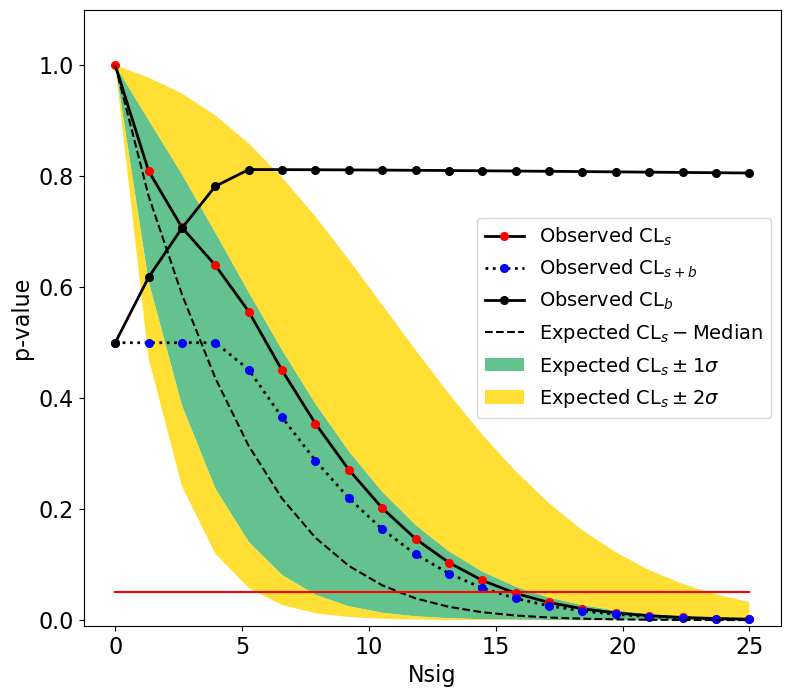

In [18]:
f = plt.figure(figsize=(9, 8))
plotlimit(poi_range, all_pvalues, alpha=0.05, CLs=True)
plt.xlabel("Nsig")
f.savefig("asy_ul.png")

In [ ]:
# f = plt.figure(figsize=(9, 8))
# plotlimit(ul, alpha=0.05, CLs=False)